# Reconstruction network analysis
**Author:** Scott Campit

## Summary
This notebook constructs network representations of multiple -omics datasets and regulatory layers.

## Import libraries

In [46]:
# General Libraries
import re
import json

# Data Science Libraries
import matplotlib.pyplot as plt
import pandas
import numpy
import networkx as nx

# Constraint-based metabolic modeling toolboxes
import cobra
%matplotlib inline

# Cytoscape
from py2cytoscape.data.cyrest_client import CyRestClient
from cyjupyter import Cytoscape

## Import Network Reconstruction
The exercise below will use the epigenome-scale metabolic reconstruction as the metabolic network.

In [2]:
model_path = '/home/scampit/Data/Reconstructions/eGEM/07132020.mat'
model = cobra.io.load_matlab_model(model_path)

/home/scampit/Envs/python/networks/lib/python3.8/site-packages/cobra/core/reaction.py:464: UserWarning: malformed gene_reaction_rule '(( 1737.1 ) and (( 1738.1 ) and ( 8050.1 )) and (( 5161.1 ) and ( 5162.1 ))) or ((( 5160.1 ) and ( 5162.1 )) and ( 1737.1 ) and (( 1738.1 ) and 8050.1 )))' for <Reaction PDHn at 0x7f0504f55a00>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))


First, we'll get some of the key identifiers

In [3]:
recon1Graph = nx.DiGraph()
for rxn in model.reactions:
    
    rxnFormula = re.sub(r'\s*\d+\.\d+\s*', '', rxn.reaction)
    # Get reactions, productions, and network directionality
    if "-->" in rxnFormula:
        reactants, products = rxnFormula.split('-->')
        reactionType = 'IRREVERSIBLE'
    elif "<=>" in rxnFormula:
        reactants, products = rxnFormula.split('<=>')
        reactionType = 'REVERSIBLE'
    # Construct directed network by products
    for prod in products.split('+'):
        for react in reactants.split('+'):
            if reactionType == 'IRREVERSIBLE':
                #recon1Graph.add_edge(u_of_edge=react.strip(), v_of_edge=prod.strip(), 
                #                     color='blue', label=rxn.id)
                try:
                    recon1Graph.add_edge(u_of_edge=model.genes.get_by_id(rxn), 
                                         v_of_edge=react.strip(), 
                                         color='green', label=rxn.id)
                    recon1Graph.add_edge(u_of_edge=model.genes.get_by_id(rxn), 
                                         v_of_edge=prod.strip(), 
                                         color='green', label=rxn.id)
                except KeyError:
                    pass
                    
            elif reactionType == 'REVERSIBLE':
                #recon1Graph.add_edge(u_of_edge=react.strip(), v_of_edge=prod.strip(), 
                #                     color='blue', label=rxn.id)
                #recon1Graph.add_edge(u_of_edge=prod.strip(), v_of_edge=react.strip(), 
                #                     color='blue', label=rxn.id)
                try:
                    recon1Graph.add_edge(u_of_edge=model.genes.get_by_id(rxn), 
                                         v_of_edge=react.strip(), 
                                         color='green', label=rxn.id)
                    recon1Graph.add_edge(u_of_edge=model.genes.get_by_id(rxn), 
                                         v_of_edge=prod.strip(), 
                                         color='green', label=rxn.id)
                except KeyError:
                    pass
                

This codeblock creates a function that gets the unique Entrez IDs in the metabolic model for a given reaction. This will allow me to extract genes for each reaction to construct the graph.

In [4]:
# Get reaction
def get_unique_genes(rxn_obj):
    """
    get_unique_genes gets the unique genes from a reaction object in the 
    metabolic reconstruction. If the reaction object does not have genes
    associated with it, it will return an empty list.
    
    param rxn_obj: A COBRA reaction object.
    return:        A list of unique Entrez IDs for a given reaction in the 
                   metabolic reconstruction.
    """
    
    gpr = rxn_obj.gene_reaction_rule
    gene_list = list()
    
    try:
        all_genes = re.split('or | and', gpr)
        all_genes = list(map(str.strip, all_genes))

        gene_list = []
        for i in range(len(all_genes)):
            tmp = re.sub('[()]', '', all_genes[i])
            tmp = int(float(tmp))
            gene_list.append(tmp)
        gene_list = list(set(gene_list))
    
    except ValueError:
        pass
    
    return gene_list

print("Case studies", '\n')
rxn1 = model.reactions[1]
print("Example of no gene associated with reaction")
print("Reaction: ", rxn1)
print("Gene:", get_unique_genes(rxn1), '\n')

rxn2 = model.reactions[3000]
print("Example of multiple isoforms for a single gene associated with reaction")
print("Reaction: ", rxn2)
print("Gene: ", get_unique_genes(rxn2), '\n')

rxn3 = model.reactions[100]
print("Example of multiple genes associated with reaction")
print("Reaction: ", rxn3)
print("Genes: ", get_unique_genes(rxn3), '\n')

Case studies 

Example of no gene associated with reaction
Reaction:  10FTHF5GLUtm: 10fthf5glu_m --> 10fthf5glu_c
Gene: [] 

Example of multiple isoforms for a single gene associated with reaction
Reaction:  PI3PP: h2o_c + pail3p_hs_c --> pail_hs_c + pi_c
Gene:  [8897] 

Example of multiple genes associated with reaction
Reaction:  4NPHSULT: 4nph_c + paps_c --> 4nphsf_c + h_c + pap_c
Genes:  [6817, 6818, 6799] 



Let's now construct the graph! Here is a function that will turn a series of reactions into a graph.

In [21]:
def create_reconstruction_graph(model):
    """
    """
    
    G = nx.DiGraph()
    for rxn in model:

        # From each reaction, get some sort of identifier
        rxnName = rxn.id
        rxnFormula = re.sub(r'\s*\d+\.\d+\s*', '', rxn.reaction)
        genes = get_unique_genes(rxn)

        # See if the reaction is irreversible or reversible
        if "-->" in rxnFormula:
            reactants, products = rxnFormula.split('-->')
            reactionType = 'IRREVERSIBLE'
        elif "<=>" in rxnFormula:
            reactants, products = rxnFormula.split('<=>')
            reactionType = 'REVERSIBLE'

        # Construct directed network by products
        for prod in products.split('+'):
            for react in reactants.split('+'):
                if reactionType == 'IRREVERSIBLE':
                    #recon1Graph.add_edge(u_of_edge=react.strip(), v_of_edge=prod.strip(), 
                    #                     color='blue', label=rxn.id)
                    for g in genes:
                        G.add_edge(u_of_edge=g, 
                                             v_of_edge=react.strip(), 
                                             color='green', label=rxnName)
                        G.add_edge(u_of_edge=g, 
                                             v_of_edge=prod.strip(), 
                                             color='green', label=rxnName)

                elif reactionType == 'REVERSIBLE':
                    #recon1Graph.add_edge(u_of_edge=react.strip(), v_of_edge=prod.strip(), 
                    #                     color='blue', label=rxn.id)
                    #recon1Graph.add_edge(u_of_edge=prod.strip(), v_of_edge=react.strip(), 
                    #                     color='blue', label=rxn.id)
                    for g in genes:
                        G.add_edge(u_of_edge=g, 
                                             v_of_edge=react.strip(), 
                                             color='green', label=rxnName)
                        G.add_edge(u_of_edge=g, 
                                             v_of_edge=prod.strip(), 
                                             color='green', label=rxnName)
    return G

To do a sanity check, let's construct the glycolytic pathway. If there is no gene associated with a given reaction, that's fine! We'll fill it with a space.

In [36]:
glycolysis_rxns = []
for rxn in model.reactions:
    if rxn.subsystem == 'Glycolysis/Gluconeogenesis':
        glycolysis_rxns.append(rxn)
glycolysis = create_reconstruction_graph(glycolysis_rxns)

Now let's construct the glycolysis visualization!

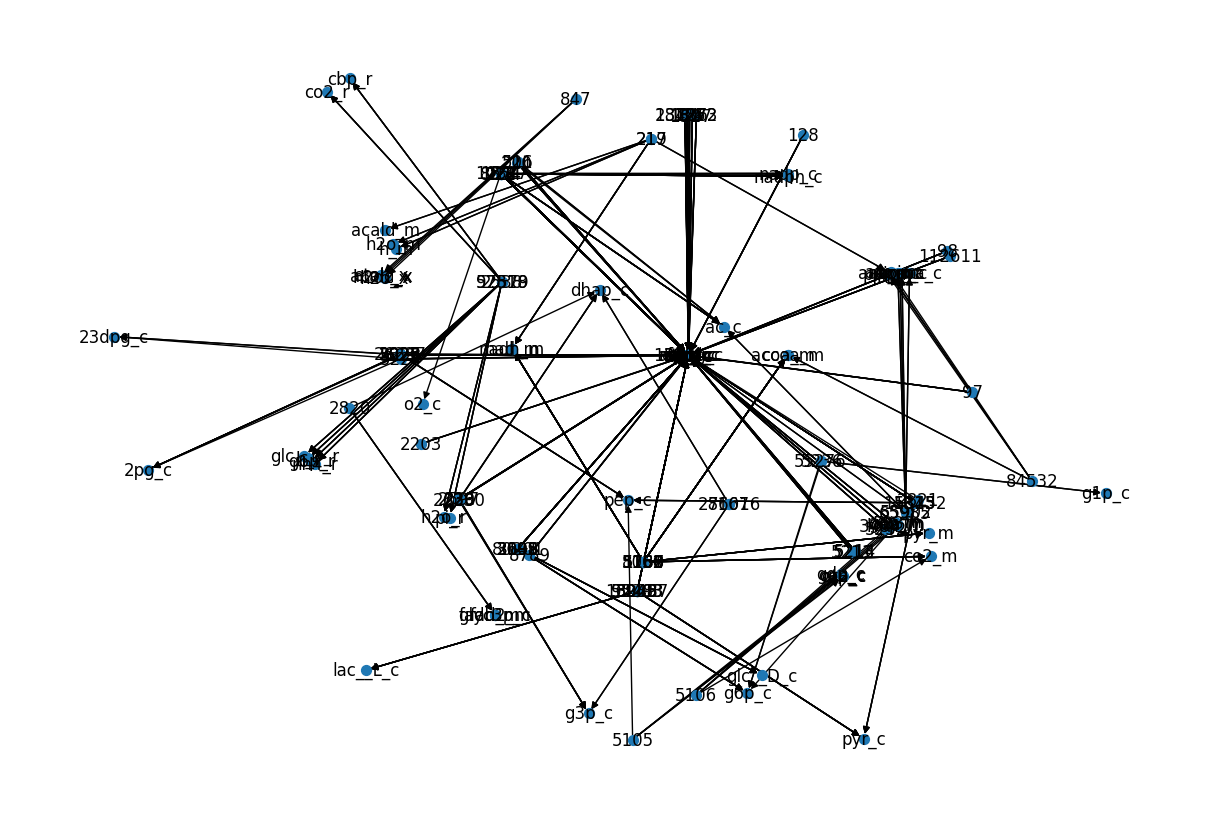

In [37]:
plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
pos = nx.kamada_kawai_layout(glycolysis)
nx.draw(glycolysis, pos, node_size=50, with_labels=True)
plt.show()

In [69]:
cyG = nx.cytoscape_data(glycolysis)
G = glycolysis

# Calculate betweenness centrarity of the graph (for both nodes and edges)
bc = nx.betweenness_centrality(G)
ebc = nx.edge_betweenness_centrality(G)
nx.set_node_attributes(G, bc, 'betweenness')
nx.set_edge_attributes(G, ebc, 'betweenness')

# Pick min and max for each data
bc_min = min(bc.values())
bc_max = max(bc.values())
ebc_min = min(ebc.values())
ebc_max = max(ebc.values())

# For nodes
mapper = 'mapData(betweenness,' + str(bc_min) + ',' + str(bc_max) + ', 5, 50)'
op_mapper = 'mapData(betweenness,' + str(bc_min) + ',' + str(bc_max) + ', 0.3, 1)'
color_mapper = 'mapData(betweenness,' + str(bc_min) + ',' + str(bc_max) + ', #EFEFEF, #00897B)'

# For edges
edge_mapper = 'mapData(betweenness,' + str(ebc_min) + ',' + str(ebc_max) + ', 1, 10)'
edge_op_mapper = 'mapData(betweenness,' + str(ebc_min) + ',' + str(ebc_max) + ', 0.3, 1)'

# Build a style
custom_visual_style = [
    {
        'selector': 'node',
        'style': {
            'background-color': color_mapper,
            'width': mapper,
            'height': mapper,
            'background-opacity': op_mapper,
            'label': "data(id)"
        }
    },
    {
        'selector': 'edge',
        'style': {
            'width': edge_mapper,
            'opacity': edge_op_mapper,
            'line-color': '#333333'        
        }
    }
]
Cytoscape(data=cyG, 
          layout_name='circle', 
          visual_style=custom_visual_style, 
          background='#EEEEEE')

Cytoscape(background='#EEEEEE', data={'data': [], 'directed': True, 'multigraph': False, 'elements': {'nodes':…

In [70]:
from py2cytoscape import cyrest
import py2cytoscape.cytoscapejs as renderer
renderer.render(network=cyG, 
                height=800, width=800, 
                layout_algorithm='circle', background='#EEEEEE')

In [80]:
import ipycytoscape
cyobj = ipycytoscape.CytoscapeWidget()
cyobj.graph.add_graph_from_networkx(G)
cyobj.set_style([{
                          "selector":"node",
                          "style":{
                             "height":20,
                             "width":20,
                             "background-color":"#30c9bc"
                          }
                       },
                       {
                          "selector":"edge",
                          "style":{
                             "curve-style":"haystack",
                             "haystack-radius":0,
                             "width":5,
                             "opacity":0.5,
                             "line-color":"#a8eae5"
                          }
                       }])

In [81]:
display(cyobj)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'height': 2…